In [1]:
import pandas as pd

In [2]:
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datasets import load_unit_test
df_train, df_train_y= load_unit_test(split="train")
df_test, df_test_y = load_unit_test(split="test")


In [3]:
df_train['class']=df_train_y
df_test['class']=df_test_y

In [4]:
from pypelines import ts_classification_pipeline as pipe

In [5]:
tsc = pipe.TSClassificationPipeline(data=df_train,
                                    target_column='class',
                                    models=['ShapeDTW'],
                                    test_data=df_test,positive_class='2')


In [6]:
tsc.code_to_clipboard()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END n_neighbors=1, shape_descriptor_function=raw;, score=1.000 total time=   1.3s
[CV 2/3] END n_neighbors=1, shape_descriptor_function=raw;, score=1.000 total time=   0.5s
[CV 3/3] END n_neighbors=1, shape_descriptor_function=raw;, score=1.000 total time=   0.5s
[CV 1/3] END n_neighbors=6, shape_descriptor_function=raw;, score=0.571 total time=   0.5s
[CV 2/3] END n_neighbors=6, shape_descriptor_function=raw;, score=0.714 total time=   0.4s
[CV 3/3] END n_neighbors=6, shape_descriptor_function=raw;, score=1.000 total time=   0.5s
      model         metric     value
4  ShapeDTW  roc_auc_score  0.858333
      model         metric     value
4  ShapeDTW  roc_auc_score  0.858333
The best model is ShapeDTW with 0.8583333333333333 as roc_auc_score
Predictions from best model are stored in test_predictions


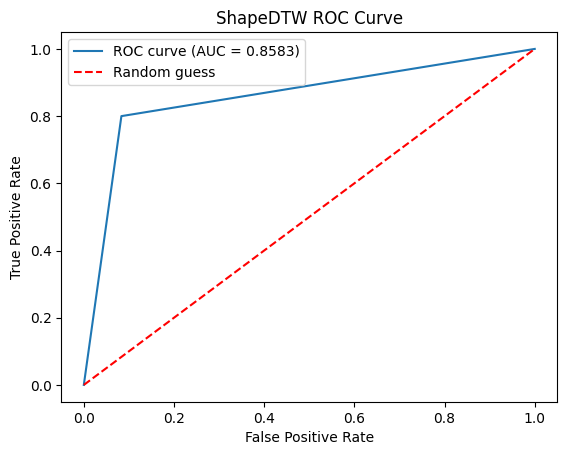

In [7]:

from sktime import *
from sklearn.metrics import accuracy_score


import pandas as pd
import numpy as np


# target dataframe: df_train
target = "class"
features = list(df_train.columns.drop("class"))

# train test split
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

model_comparison_list = []

##### End of Data Processing Pipeline #####


##### Model Pipeline for ShapeDTW #####

from sktime.classification.distance_based import ShapeDTW
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,make_scorer,f1_score,precision_score,recall_score,roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
ShapeDTW_param_grid = {
"n_neighbors": np.arange(1, 10, 5),
"shape_descriptor_function": ['raw'],
}

ShapeDTW_model = ShapeDTW()

# Create the grid search
ShapeDTW_grid_search = GridSearchCV(estimator=ShapeDTW_model, param_grid=ShapeDTW_param_grid, cv=3, scoring=make_scorer(accuracy_score), verbose=3)
ShapeDTW_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
ShapeDTW_best_estimator = ShapeDTW_grid_search.best_estimator_

# Store results as a dataframe  
ShapeDTW_search_results = pd.DataFrame(ShapeDTW_grid_search.cv_results_)

# Generate Predictions
ShapeDTW_predictions = pd.DataFrame(ShapeDTW_best_estimator.predict(X_test))
ShapeDTW_predictions_prob = ShapeDTW_best_estimator.predict_proba(X_test)
ShapeDTW_predictions_prob_df = pd.DataFrame()
ShapeDTW_predictions_prob_df[ShapeDTW_grid_search.classes_[0]] = ShapeDTW_predictions_prob[:,0]
ShapeDTW_predictions_prob_df[ShapeDTW_grid_search.classes_[1]] = ShapeDTW_predictions_prob[:,1] 


# Generate Model Metrics
ShapeDTW_accuracy = accuracy_score(y_test, ShapeDTW_predictions.iloc[:,0])
ShapeDTW_f1_score = f1_score(y_test, ShapeDTW_predictions.iloc[:,0],pos_label='2')
ShapeDTW_precision = precision_score(y_test, ShapeDTW_predictions.iloc[:,0],pos_label='2')
ShapeDTW_recall = recall_score(y_test, ShapeDTW_predictions.iloc[:,0],pos_label='2')
ShapeDTW_roc_auc_score = roc_auc_score(y_test, ShapeDTW_predictions_prob_df[ShapeDTW_grid_search.classes_[1]])
ShapeDTW_performance_metrics = [['ShapeDTW','accuracy',ShapeDTW_accuracy], 
                                  ['ShapeDTW','f1_score',ShapeDTW_f1_score],
                                  ['ShapeDTW','precision', ShapeDTW_precision],
                                  ['ShapeDTW','recall', ShapeDTW_recall],
                                  ['ShapeDTW','roc_auc_score', ShapeDTW_roc_auc_score]]
ShapeDTW_performance_metrics = pd.DataFrame(ShapeDTW_performance_metrics, columns=['model','metric', 'value'])
fpr, tpr, thresholds = roc_curve(y_test, ShapeDTW_predictions_prob_df[ShapeDTW_grid_search.classes_[1]],pos_label='2')
roc_auc = auc(fpr, tpr)

# ROC Curve plot
ShapeDTW_roc_auc_plot, ShapeDTW_roc_auc_plot_ax = plt.subplots()
ShapeDTW_roc_auc_plot_ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
ShapeDTW_roc_auc_plot_ax.plot([0, 1], [0, 1], 'r--', label='Random guess')
# Set axis labels and title
ShapeDTW_roc_auc_plot_ax.set_xlabel('False Positive Rate')
ShapeDTW_roc_auc_plot_ax.set_ylabel('True Positive Rate')
ShapeDTW_roc_auc_plot_ax.set_title(f'ShapeDTW ROC Curve')
# Add legend
ShapeDTW_roc_auc_plot_ax.legend()


print(ShapeDTW_performance_metrics[ShapeDTW_performance_metrics['metric'] == 'roc_auc_score'])
model_comparison_list.append(ShapeDTW_performance_metrics)##### End of Model Pipeline for ShapeDTW #####
##### Model Comparison #####
table = pd.concat(model_comparison_list)
table = table.sort_values(by=['value'], ascending=False)
table = table[table['metric'] == 'roc_auc_score']
print(table)
print(f"The best model is {table['model'].iloc[0]} with {table['value'].iloc[0]} as {table['metric'].iloc[0]}")

# Predict test data using the best model
test_predictions = eval(table['model'].iloc[0]+"_best_estimator").predict(X_test)
print('Predictions from best model are stored in test_predictions')
